# Quick start (distributed)

> Minimal example of distributed training with MLForecast

## Main concepts

The main component for distributed training with mlforecast is the `DistributedMLForecast` class, which abstracts away:

* Feature engineering and model training through `DistributedMLForecast.fit`
* Feature updates and multi step ahead predictions through `DistributedMLForecast.predict`

## Setup

In order to perform distributed training you need a dask cluster. In this example we'll use a local cluster but you can replace it with any other type of remote cluster and the processing will take place there.

In [ ]:
from dask.distributed import Client, LocalCluster

cluster = LocalCluster(n_workers=2, threads_per_worker=1)  # change this to use a remote cluster
client = Client(cluster)

## Data format

The data is expected to be a dask dataframe in long format, that is, each row represents an observation of a single serie at a given time, with at least three columns:

* `id_col`: column that identifies each serie. **It is highly recommended to have this as the index, because dask creates the partitions based on the index and this makes sure that each serie is within a single partition.**
* `target_col`: column that has the series values at each timestamp.
* `time_col`: column that contains the time the series value was observed. These are usually timestamps, but can also be consecutive integers.

Here we present an example with synthetic data.

In [ ]:
import dask.dataframe as dd
from mlforecast.utils import generate_daily_series

In [ ]:
series = generate_daily_series(100, with_trend=True)
series

,ds,y
unique_id,,
id_00,2000-01-01,0.497650
id_00,2000-01-02,1.554489
id_00,2000-01-03,2.734311
id_00,2000-01-04,4.028039
id_00,2000-01-05,5.366009
...,...,...
id_99,2000-06-25,34.165302
id_99,2000-06-26,28.277320
id_99,2000-06-27,29.450129


Here we can see that the index goes from `id_00` to `id_99`, which means we have 100 different series stacked together.

We also have the `ds` column that contains the timestamps, in this case with a daily frequency, and the `y` column that contains the series values in each timestamp.

In order to perform distributed processing and training we need to have these in a dask dataframe, this is typically done loading them directly in a distributed way, for example with `dd.read_parquet`.

In [ ]:
series_ddf = dd.from_pandas(series, npartitions=2)
series_ddf

,ds,y
npartitions=2,,
id_00,datetime64[ns],float64
id_49,...,...
id_99,...,...


We now have a dask dataframe with two partitions which will be processed independently in each machine and their outputs will be combined to perform distributed training.

## Modeling

In [ ]:
import random
import matplotlib.pyplot as plt

def plot_sample(df):
    idxs = df.index.unique()
    random.seed(0)
    sample_idxs = random.choices(idxs, k=4)
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 6), gridspec_kw=dict(hspace=0.5))
    for uid, axi in zip(sample_idxs, ax.flat):
        df.loc[uid].set_index('ds').plot(ax=axi, title=uid)

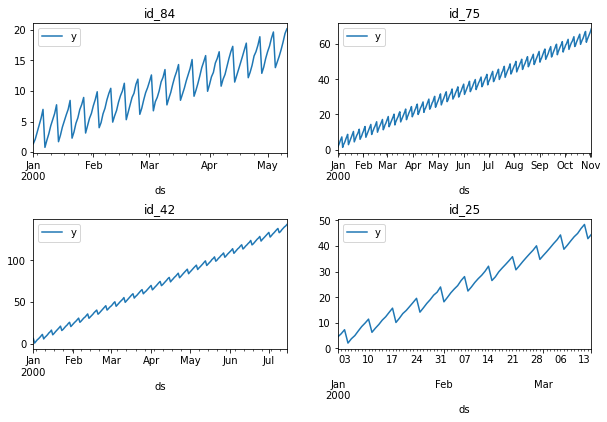

In [ ]:
plot_sample(series)

We can see that the series have a clear trend, so we can take the first difference, i.e. take each value and subtract the value at the previous month. This can be achieved by setting `differences=[1]`.

We can then train a LightGBM model using the value from the same day of the week at the previous week (lag 7) as a feature, this is done by passing `lags=[7]`.

In [ ]:
from mlforecast.distributed import DistributedMLForecast
from mlforecast.distributed.models.lgb import LGBMForecast

In [ ]:
fcst = DistributedMLForecast(
    models=LGBMForecast(verbosity=-1),
    freq='D',
    lags=[7],
    differences=[1],
)
fcst.fit(series_ddf, id_col='index', time_col='ds', target_col='y')

/home/jose/mambaforge/envs/mlforecast/lib/python3.9/site-packages/lightgbm/dask.py:525: UserWarning: Parameter n_jobs will be ignored.
  _log_warning(f"Parameter {param_alias} will be ignored.")


Finding random open ports for workers
[LightGBM] [Info] Trying to bind port 34477...
[LightGBM] [Info] Binding port 34477 succeeded
[LightGBM] [Info] Listening...
[LightGBM] [Warning] Connecting to rank 1 failed, waiting for 200 milliseconds
[LightGBM] [Info] Trying to bind port 53997...
[LightGBM] [Info] Binding port 53997 succeeded
[LightGBM] [Info] Listening...
[LightGBM] [Info] Connected to rank 1
[LightGBM] [Info] Connected to rank 0
[LightGBM] [Info] Local rank: 1, total number of machines: 2
[LightGBM] [Info] Local rank: 0, total number of machines: 2
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1


DistributedMLForecast(models=[LGBMForecast], freq=<Day>, lag_features=['lag-7'], date_features=[], num_threads=1, client=<Client: 'tcp://127.0.0.1:42101' processes=2 threads=2, memory=15.50 GiB>)

The previous line computed the features and trained the model, so now we're ready to compute our forecasts.

## Forecasting

Compute the forecast for the next 14 days.

In [ ]:
preds = fcst.predict(14)
preds

,ds,LGBMRegressor
npartitions=2,,
id_00,datetime64[ns],float64
id_49,...,...
id_99,...,...


These are returned as a dask dataframe as well. If it's safe (memory-wise) we can bring them to the main process.

In [ ]:
local_preds = preds.compute()

## Visualize results

We can visualize what our prediction looks like.

In [ ]:
import pandas as pd

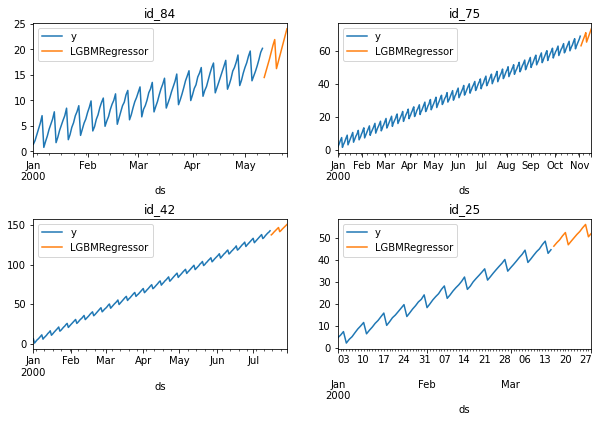

In [ ]:
plot_sample(pd.concat([series, local_preds]))

And that's it! You've trained a distributed LightGBM model and computed predictions for the next 14 days.